In [1759]:
import matplotlib
#import matplotlib.pyplot as plt
import os
import json
import pickle
import numpy as np
from pathlib import Path
from enum import Enum
import scipy.constants as sc
from scipy.signal import savgol_filter
#from tensorboard.backend.event_processing.event_file_loader import EventFileLoader

plt = matplotlib.pyplot

In [1760]:
class Tag(Enum):
    CUMULATIVE_REWARD = "cumulative_rewards"
    EP_LENGTH = "ep_length"
    DOOR_PASSAGE = "passage"
    COLLISION_INITIAL = "initial"
    COLLISION_STAY = "stay"
    COLLISION_TOTAL = "total"
    DOOR_GOOD = "good_passage"
    DOOR_BAD = "bad_passage"

class Plot(Enum):
    COLLISION = 0
    ENV1 = 1
    ENV2 = 2
    LINEPLOT = 3
    RESULT_DATA_ENV1 = 4
    RESULT_DATA_ENV2 = 5
    DOOR = 6
    DOOR_HIST = 7
    SENSOR_STUDY_EP_LENGTH = 8
    SENSOR_STUDY_REWARD = 8

tag_colors = {
    Tag.CUMULATIVE_REWARD: "C1",
    Tag.EP_LENGTH: "C2"
    }

Select from what run to get data. Also choose the Type of data.

In [1761]:
multiple_runs = True
selected_runs: list[int] =  list(range(6072, 6081)) #[6072]
plot_step = 5
plot_all = True
selected_tag = Tag.EP_LENGTH
selected_plot = Plot.SENSOR_STUDY

AttributeError: SENSOR_STUDY

In [ ]:
"""Get y data fro the summary dict using the ID of the training run.
The tag specifies the selected type of data."""
def get_y_data(summary_dict: dict, id: int, tag: Tag):
    try:
        if tag in [Tag.CUMULATIVE_REWARD, Tag.EP_LENGTH]:
            return summary_dict[id]["env"][tag.value]
        if tag in [Tag.DOOR_PASSAGE, Tag.DOOR_BAD, Tag.DOOR_GOOD]:
            return summary_dict[id]["door"][tag.value]
        if tag in [Tag.COLLISION_STAY, Tag.COLLISION_INITIAL, Tag.COLLISION_STAY]:
            return summary_dict[id]["collision"][tag.value]
    except ValueError:
        return []


In [ ]:
"""Get x data from the summary dict. Is based on the recorded step."""
def get_x_data(summary_dict: dict, id: int, tag: Tag):
    d = len(get_y_data(summary_dict, id, tag))
    return summary_dict[id]["steps"][:d]

In [ ]:
"""Filter data to smooth plots."""
def filter_data(data):
    try: 
        return savgol_filter(data, 15, 2)
    except ValueError:
        return []

In [ ]:
def cut_arrays_to_same_length(a: np.ndarray, b:np.ndarray):
    if len(a) != len(b):
        if len(a) < len(b):
            d = len(a)
            b = b[:d]
        else:
            d = len(b)
            a = a[:d]
    return a, b

In [ ]:
# Load the pickle with all the run data.
summary_file_path = Path("C:/Users/max.muehlefeldt/Documents/GitHub/unity-machine-learning/python/basic_rl_env/summary_dict.pickle").absolute()

with open(summary_file_path, mode="rb") as file:
    summary_dict = pickle.load(file)

In [ ]:
# Global plot settings
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams["font.family"] = 'serif'

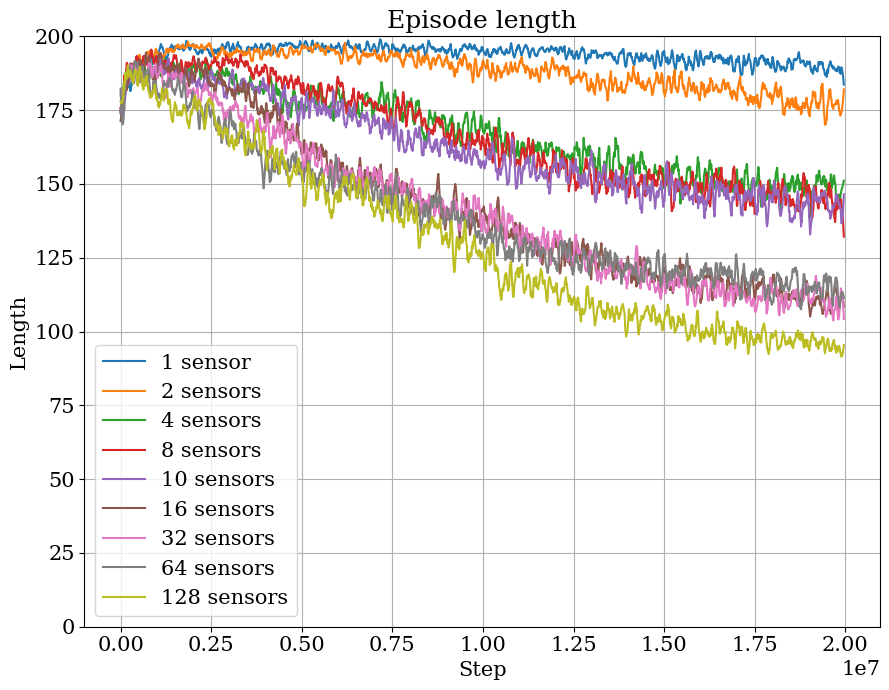

In [ ]:
if selected_plot in [Plot.SENSOR_STUDY_EP_LENGTH, Plot.SENSOR_STUDY_REWARD]:
    fig = plt.figure(figsize=(9, 7))
    #fig = plt.figure()
    fig.patch.set_alpha(0.)
    
    gs = fig.add_gridspec(ncols=1, nrows=1, figure=fig)

    # First plot.
    #selected_tag = Tag.EP_LENGTH
    axs_first = fig.add_subplot(gs[0, 0])
    #fig.suptitle(f"Runs {selected_runs[0]} - {selected_runs[-1]}", y=0.95)
    #fig.tight_layout()

    for id in selected_runs:
        #sensor_count = content[id]['stats']['sensorCount']
        sensor_count = summary_dict[id]["file_contents"]["unity_config"]["sensorCount"]
        #print(sensor_count)
        #run_label = f"{sensor_count} sensor" if sensor_count == 1 else f"{sensor_count} sensors, run {id}"
        run_label = f"{sensor_count} sensor" if sensor_count == 1 else f"{sensor_count} sensors"
        #run_label += f", no LSTM" if id == 6108 else ", with LSTM"

        #x = content[id]["x_values"][selected_tag]
        x = get_x_data(summary_dict, id, selected_tag)
        #y = savgol_filter( content[id]["y_values"][selected_tag], 15, 2)
        y = savgol_filter( get_y_data(summary_dict, id, selected_tag), 15, 2)
        #x = content[id]["x_values"][selected_tag]
        axs_first.plot(
            x, 
            y,
            #color=tag_colors[selected_tag]
            label=run_label
            )
    
    
    if selected_tag is Plot.SENSOR_STUDY_REWARD:
        #axs_first.set_ylim(-2, 1.5)
        axs_first.set_ylim(-2, 1.1)
        #axs_first.axhline(1.25, label="Reward limit = 1.25", color="C3", linestyle="dashed")
        axs_first.axhline(1.0, label="Reward limit = 1.0", color="C3", linestyle="dashed")
        axs_first.set_ylabel("Reward")
        axs_first.set_title("Cumulative reward")

    elif selected_tag is Plot.SENSOR_STUDY_EP_LENGTH:
        axs_first.set_ylim(0, 200)
        axs_first.set_ylabel("Length")
        axs_first.set_title("Episode length")
    
    #elif selected_tag is Tag.DOOR_PASSAGE:
    #    axs_first.set_ylim(-1, 1)
    #    axs_first.set_ylabel("Passage Quality")
    #    axs_first.set_title("Door passage")
    
    axs_first.set_xlabel("Step")
    
    axs_first.legend()
    axs_first.grid()   

    plt.subplots_adjust(hspace=0.4)
    plt.style.use("default")
    plt.tight_layout()
    #plt.savefig(f"{selected_run}_all.pdf")
    fig.savefig(f"{selected_runs[0]}-{selected_runs[-1]}_{selected_tag}.pdf")

In [ ]:
if selected_plot is Plot.COLLISION:
    fig = plt.figure(figsize=(9, 7))
    fig.patch.set_alpha(0.)
    gs = fig.add_gridspec(ncols=1, nrows=1, figure=fig)
    axs_first = fig.add_subplot(gs[0, 0])

    for id in selected_runs:
        #sensor_count = content[id]['stats']['sensorCount']
        sensor_count = summary_dict[id]["file_contents"]["unity_config"]["sensorCount"]
        #print(sensor_count)
        #run_label = f"{sensor_count} sensor" if sensor_count == 1 else f"{sensor_count} sensors, run {id}"
        run_label = f"{sensor_count} sensor" if sensor_count == 1 else f"{sensor_count} sensors"
        #run_label += f", no LSTM" if id == 6108 else ", with LSTM"

        #x = content[id]["x_values"][selected_tag]
        x = get_x_data(summary_dict, id, selected_tag)
        #y = savgol_filter( content[id]["y_values"][selected_tag], 15, 2)
        #y = savgol_filter( get_y_data(summary_dict, id, selected_tag), 15, 2)
        #x = content[id]["x_values"][selected_tag]
        #axs_first.plot(
        #    x, 
        #    y,
        #    #color=tag_colors[selected_tag]
        #    label=run_label
        #    )

        
        y_initial = filter_data(get_y_data(summary_dict, id, Tag.COLLISION_INITIAL))
        y_stay = filter_data(get_y_data(summary_dict, id, Tag.COLLISION_STAY))

        if len(y_initial) != len(y_stay):
            if len(y_initial) < len(y_stay):
                d = len(y_initial)
                y_stay = y_stay[:d]
                x = x[:d]
            else:
                d = len(y_stay)
                y_initial = y_initial[:d]
                x = x[:d]
        
        y = np.vstack([y_initial, y_stay])

        

        axs_first.stackplot(
            x, y,
            labels=["Initial contact", "Continued contact"],
            alpha=0.8
        )

        axs_first.set_ylim(0, 200)
    #if selected_tag is Tag.CUMULATIVE_REWARD:
    #    #axs_first.set_ylim(-2, 1.5)
    #    axs_first.set_ylim(-2, 1.1)
        #axs_first.axhline(1.25, label="Reward limit = 1.25", color="C3", linestyle="dashed")
    #    axs_first.axhline(1.0, label="Reward limit = 1.0", color="C3", linestyle="dashed")
        axs_first.set_ylabel("Count")
        axs_first.set_title("Collisions")

    #elif selected_tag is Tag.EP_LENGTH:
    #    axs_first.set_ylim(0, 200)
    #    axs_first.set_ylabel("Length")
    #    axs_first.set_title("Episode length")
    
    #elif selected_tag is Tag.DOOR_PASSAGE:
    #    axs_first.set_ylim(-1, 1)
    #    axs_first.set_ylabel("Passage Quality")
    #    axs_first.set_title("Door passage")
    
        axs_first.set_xlabel("Step")
        
        axs_first.legend(title=f"Run {id}")
        axs_first.grid()   

        plt.subplots_adjust(hspace=0.4)
        plt.style.use("default")
        plt.tight_layout()
        #plt.savefig(f"{selected_run}_all.pdf")
        fig.savefig(f"{selected_runs[0]}-{selected_runs[-1]}_{selected_plot}.pdf")

       

In [ ]:
if selected_plot in [Plot.ENV1, Plot.ENV2]:
    fig = plt.figure(figsize=(9, 7))
    #fig = plt.figure()
    fig.patch.set_alpha(0.)
    
    gs = fig.add_gridspec(ncols=1, nrows=1, figure=fig)

    # First plot.
    #selected_tag = Tag.EP_LENGTH
    axs_first = fig.add_subplot(gs[0, 0])
    #fig.suptitle(f"Runs {selected_runs[0]} - {selected_runs[-1]}", y=0.95)
    #fig.tight_layout()

    for id in selected_runs:
        #sensor_count = content[id]['stats']['sensorCount']
        sensor_count = summary_dict[id]["file_contents"]["unity_config"]["sensorCount"]
        #print(sensor_count)
        #run_label = f"{sensor_count} sensor" if sensor_count == 1 else f"{sensor_count} sensors, run {id}"

        run_label = f"Cumulutive reward"
        selected_tag = Tag.CUMULATIVE_REWARD
        #x = content[id]["x_values"][selected_tag]
        x = get_x_data(summary_dict, id, selected_tag)
        #y = savgol_filter( content[id]["y_values"][selected_tag], 15, 2)
        y = filter_data(get_y_data(summary_dict, id, selected_tag))
        #x = content[id]["x_values"][selected_tag]
        axs_first.plot(
            x, 
            y,
            color=tag_colors[selected_tag],
            label="Cumulative reward",
            linewidth=2.0,
            )
        axs_first.set_ylim(
            -2, 
            1.1 if selected_plot is Plot.ENV1 else 1.6
        )
        axs_first.set_ylabel("Reward")
        reward_label = "Reward limit = 1.0" if selected_plot is Plot.ENV1 else  "Reward limit = 1.5"
        axs_first.axhline(
            1.0 if selected_plot is Plot.ENV1 else 1.5,
            label=reward_label, color="C3", linestyle="dashed"
        )

        selected_tag = Tag.EP_LENGTH
        x = get_x_data(summary_dict, id, selected_tag)
        y = filter_data(get_y_data(summary_dict, id, selected_tag))
        axs_second = axs_first.twinx()
        axs_second.plot(
            x, 
            y,
            color=tag_colors[selected_tag],
            label="Episode length",
            linewidth=2.0,
            )
        axs_second.set_ylim(0, 200)
        axs_second.set_ylabel("Episode Length")
        #fig.suptitle("Cumulative reward and episode length")
    
    """if selected_tag is Tag.CUMULATIVE_REWARD:
        #axs_first.set_ylim(-2, 1.5)
        axs_first.set_ylim(-2, 1.1)
        #axs_first.axhline(1.25, label="Reward limit = 1.25", color="C3", linestyle="dashed")
        axs_first.axhline(1.0, label="Reward limit = 1.0", color="C3", linestyle="dashed")
        axs_first.set_ylabel("Reward")
        axs_first.set_title("Cumulative reward")

    elif selected_tag is Tag.EP_LENGTH:
        axs_first.set_ylim(0, 200)
        axs_first.set_ylabel("Length")
    axs_first.set_title("Episode length")"""
    axs_first.set_title("Cumulative reward and episode length")
    axs_first.set_xlabel("Step")
    
    axs_second.legend()
    axs_first.legend(title=f"Run {id}")
    axs_second.grid()
    #axs_first.grid()

    plt.subplots_adjust(hspace=0.4)
    plt.style.use("default")
    plt.tight_layout()
    #plt.savefig(f"{selected_run}_all.pdf")
    fig.savefig(f"{selected_runs[0]}-{selected_runs[-1]}_{selected_plot}.pdf")

In [ ]:
if selected_plot is Plot.DOOR:
    fig = plt.figure(figsize=(9, 7))
    #fig = plt.figure()
    fig.patch.set_alpha(0.)
    
    gs = fig.add_gridspec(ncols=1, nrows=1, figure=fig)

    # First plot.
    #selected_tag = Tag.EP_LENGTH
    axs_first = fig.add_subplot(gs[0, 0])
    #fig.suptitle(f"Runs {selected_runs[0]} - {selected_runs[-1]}", y=0.95)
    #fig.tight_layout()

    for id in selected_runs:
              
        selected_tag = Tag.DOOR_BAD
        x = get_x_data(summary_dict, id, selected_tag)
        y = filter_data(get_y_data(summary_dict, id, selected_tag))
        y = -1 * y

        axs_first.plot(
            x, 
            y,
            #color=tag_colors[selected_tag],
            label="Incorrect passage",
            linewidth=2.0,
            )

        selected_tag = Tag.DOOR_GOOD
        x = get_x_data(summary_dict, id, selected_tag)
        y = filter_data(get_y_data(summary_dict, id, selected_tag))
       
        axs_first.plot(
            x, 
            y,
            label="Correct passage",
            linewidth=2.0,
            )
        
    axs_first.set_title("Door passage")
    axs_first.set_xlabel("Step")
    
    
    axs_first.legend(title=f"Run {id}")
    axs_first.grid()

    plt.subplots_adjust(hspace=0.4)
    plt.style.use("default")
    plt.tight_layout()
    #plt.savefig(f"{selected_run}_all.pdf")
    fig.savefig(f"{selected_runs[0]}-{selected_runs[-1]}_{selected_plot}.pdf")

In [ ]:
if selected_plot is Plot.DOOR_HIST:
    fig = plt.figure(figsize=(9, 7))
    #fig = plt.figure()
    fig.patch.set_alpha(0.)
    
    gs = fig.add_gridspec(ncols=1, nrows=1, figure=fig)

    # First plot.
    #selected_tag = Tag.EP_LENGTH
    axs_first = fig.add_subplot(gs[0, 0])
    #fig.suptitle(f"Runs {selected_runs[0]} - {selected_runs[-1]}", y=0.95)
    #fig.tight_layout()

    for id in selected_runs:
              
        selected_tag = Tag.DOOR_BAD
        x = get_x_data(summary_dict, id, selected_tag)
        y_bad = -1 * filter_data(get_y_data(summary_dict, id, selected_tag))
        #y = -1 * y


        #axs_first.hist(
        #    #x, 
        #    y,
        #    #color=tag_colors[selected_tag],
        #    label="Incorrect passage",
        #    linewidth=2.0,
        #    )

        selected_tag = Tag.DOOR_GOOD
        x = get_x_data(summary_dict, id, selected_tag)
        y_good = filter_data(get_y_data(summary_dict, id, selected_tag))

        y_bad, y_good = cut_arrays_to_same_length(y_bad, y_good)

        # Use a constant bin width to make the two histograms easier to compare visually
        #bin_width = 1
        #bins = np.arange(np.min([y_bad, y_good]),
                            #np.max([y_bad, y_good]) + bin_width, bin_width)
        axs_first.hist(
            #x, 
            y_bad,
            weights=-np.ones_like(y_bad),
            #bins=bins,
            label="Inorrect passage",
            )
        axs_first.hist(
            #x, 
            y_good,
            #bins=bins,
            label="Correct passage",
            )
        
    axs_first.set_title("Door passage")
    axs_first.set_xlabel("Step")
    axs_first.axhline(0, color="k")
    
    axs_first.legend()
    axs_first.grid()

    plt.subplots_adjust(hspace=0.4)
    plt.style.use("default")
    plt.tight_layout()
    #plt.savefig(f"{selected_run}_all.pdf")
    fig.savefig(f"{selected_runs[0]}-{selected_runs[-1]}_{selected_plot}.pdf")

In [ ]:
len(y_bad)

9496

## Get result data
To highlight the final performance of the NN.

In [ ]:
if selected_plot is Plot.RESULT_DATA_ENV1:
    for id in selected_runs:
        y_collision_initial = filter_data(get_y_data(summary_dict, id, Tag.COLLISION_INITIAL))
        y_collision_stay = filter_data(get_y_data(summary_dict, id, Tag.COLLISION_STAY))
        y_cumulative_reward = filter_data(get_y_data(summary_dict, id, Tag.CUMULATIVE_REWARD))
        y_ep_length = filter_data(get_y_data(summary_dict, id, Tag.EP_LENGTH))

        x_steps = get_x_data(summary_dict, id, Tag.EP_LENGTH)

        # Episode length.
        #final_cumulative_reward = np.mean(y_cumulative_reward[-10:])
        final_cumulative_reward = summary_dict[selected_runs[0]]["final_mean_reward"]
        print(f"Cumulative reward & {np.round(final_cumulative_reward, 3)} \\\\")

        final_cumulative_reward_std = summary_dict[selected_runs[0]]["final_std_reward"]
        print(f"Cumulative reward STD & {np.round(final_cumulative_reward_std, 3)} \\\\")

        final_ep_length = np.mean(y_ep_length[-10:])
        print(f"Episode length & {np.round(final_ep_length, 3)} \\\\")

        #final_collision_rate = 100 - (np.mean(y_initial[-10:]) / 10000) * 100
        final_collision_rate = (np.mean(y_initial[-10:]) / 10000) * 100
        #print(100 -  / 10000 * 100)
        print(f"Collision rate & {np.round(final_collision_rate, 3)}\% \\\\")

        performed_steps = summary_dict[selected_runs[0]]["steps"][-1]
        print(f"Performed steps & {performed_steps} \\\\")


In [ ]:
def get_passage_quality(x, y):
    return x / (x + y)

In [ ]:
if selected_plot is Plot.RESULT_DATA_ENV2:
    for id in selected_runs:
        y_collision_initial = filter_data(get_y_data(summary_dict, id, Tag.COLLISION_INITIAL))
        y_collision_stay = filter_data(get_y_data(summary_dict, id, Tag.COLLISION_STAY))
        y_cumulative_reward = filter_data(get_y_data(summary_dict, id, Tag.CUMULATIVE_REWARD))
        y_ep_length = filter_data(get_y_data(summary_dict, id, Tag.EP_LENGTH))
        y_door_passage_incorrect = filter_data(get_y_data(summary_dict, id, Tag.DOOR_BAD))
        y_door_passage_correct = filter_data(get_y_data(summary_dict, id, Tag.DOOR_GOOD))

        x_steps = get_x_data(summary_dict, id, Tag.EP_LENGTH)

        # Episode length.
        #final_cumulative_reward = np.mean(y_cumulative_reward[-10:])
        final_cumulative_reward = summary_dict[selected_runs[0]]["final_mean_reward"]
        print(f"Cumulative reward & {np.round(final_cumulative_reward, 3)} \\\\")

        final_cumulative_reward_std = summary_dict[selected_runs[0]]["final_std_reward"]
        print(f"Cumulative reward STD & {np.round(final_cumulative_reward_std, 3)} \\\\")

        final_ep_length = np.mean(y_ep_length[-10:])
        print(f"Episode length & {np.round(final_ep_length, 2)} \\\\")

        #final_collision_rate = 100 - (np.mean(y_initial[-10:]) / 10000) * 100
        final_collision_rate = (np.mean(y_initial[-10:]) / 10000) * 100
        #print(100 -  / 10000 * 100)
        print(f"Collision rate & {np.round(final_collision_rate, 3)}\% \\\\")

        performed_steps = summary_dict[selected_runs[0]]["steps"][-1]
        print(f"Performed steps & {performed_steps} \\\\")

        door_passage_quality = get_passage_quality(
            np.mean(y_door_passage_correct[-10:]),
            (-1* np.mean(y_door_passage_incorrect[-10:])))
        print(f"Door passage quality $[-1, 1]$ & {np.round(door_passage_quality, 3)} \\\\")

In [ ]:
good = np.mean(y_door_passage_correct[-10:])

bad = -1* np.mean(y_door_passage_incorrect[-10:])

(good ) / (good + bad)


0.7968900373424694

In [ ]:
np.mean(y_door_passage_incorrect[-10:])

-25.34479638009052